In [1]:
cd '/Users/jakesteinberg/Documents/CPT/vertical_structure/'

/Users/jakesteinberg/Documents/CPT/vertical_structure


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
from tqdm import tqdm
import dedalus.public as de
import math 
from mode_decompositions import vertical_modes
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# LOAD DATA
eof_path = '/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/prep_for_modes_2deg.nc'
data = xr.open_dataset(eof_path)
lon_in = data.lon.data
lat_in = data.lat.data

In [7]:
hkm = np.array([100])                               # horizontal wavelengths to solve for
azis = np.arange(8,180,32)                          # azimuths to sweep over (big control on run time of code) (angles between 0 and 180 degrees)
nazimuths = len(azis) + 2                           # add two to include along/across slope
nmodes = 2                                          # does not include zeroth mode 
z_out = np.flip(-1*data.z.data)                     # grid on which to place output (np.arange(-6000,0,100))
Nz = 148                                            # number of grid points on which to define N (modes are very sensitive this this number)
# subset ... for shorter run time/testing
lon_i = np.where((data.lon > 300) & (data.lon < 360))[0]          # longitude indices to sweep over
lat_i = np.where((data.lat > -75) & (data.lat < -10))[0]            # latitude indiced to sweep over 
N2_in = data.N2.data
gamma_in = data.gamma.data
alpha_in = data.alpha.data
z_in = -1*data.z.data
print(len(lon_i))
print(len(lat_i))
print('n_azimuths=' + str(nazimuths))

29
32
n_azimuths=8


In [8]:
# calculate all modes for each lat/lon grid point 
def master_mode(nmodes, hkm, azis, gamma_in, alpha_in, N2_in, z_in, lat_in, lon_i, lat_i, z_out):
    z_0 = z_in
    master_K = 2.*np.pi/(hkm*1e3)  
    # prep outputs 
    modes_out = np.nan*np.ones((len(lat_i), len(lon_i), len(master_K), nazimuths, len(z_out), nmodes+1)) # [K,theta,z,mode_number]
    phase_speeds_out = np.nan*np.ones((len(lat_i), len(lon_i), len(master_K), nazimuths, nmodes+1)) 
    om_out = np.nan*np.ones((len(lat_i), len(lon_i), len(master_K), nazimuths, nmodes+1))
    fbmi = np.nan*np.ones((len(lat_i), len(lon_i)))
    thetas = np.nan*np.ones((len(lat_i), len(lon_i), nazimuths))
    lambda_squared_out = np.nan*np.ones((len(lat_i), len(lon_i), len(master_K), nazimuths, nmodes+1))
    fb_c_out = np.nan*np.ones((len(lat_i), len(lon_i), nmodes+1))
    fb1_out = np.nan*np.ones((len(lat_i), len(lon_i), len(z_out)))
    count = 0
    for masteri in tqdm(range(len(lat_i))):
        for masterj in range(len(lon_i)):
            # -- smooth N2 by averaging across local lat/lon 
            # locN2 = np.nanmean(np.nanmean(N2_in[lon_i[masterj]-3:lon_i[masterj]+4][:,lat_i[masteri]-3:lat_i[masteri]+4],axis=0),axis=0) 
            # N_0 = np.sqrt(locN2) # 
            N_0 = np.sqrt(N2_in[:,lat_i[masteri],lon_i[masterj]]) # [z,lat,lon]
            # -- need only non-nan indices 
            g_i = np.where(~np.isnan(N_0))[0]
            if len(g_i) < 3:
                continue
            z_st = z_0[g_i]
            N_st = N_0[g_i]
            # -- if depth of ocean < 400 m or N2 are mostly nans, skip 
            if np.nanmax(np.abs(z_st)) <= 1500:
                continue 
            # if gamma/alpha is not defined 
            if ~np.isfinite(gamma_in[lat_i[masteri],lon_i[masterj]]):
                continue 
            # if gamma/alpha is too large
            if (np.abs(gamma_in[lat_i[masteri],lon_i[masterj]]) > 1) | (np.abs(alpha_in[lat_i[masteri],lon_i[masterj]]) > 1):
                continue
            # -- smoothing again
            # N_st = savgol_filter(N_st,15,5)
            # print(N_st)

            # -- Domain (depends on z in cell above)
            h = np.round(np.nanmax(np.abs(z_st)),-1) - 10  # 3100
            z_basis = de.Chebyshev('z', Nz, interval=(-h, -5), dealias=3/2)
            domain = de.Domain([z_basis], np.complex128);
            ncc1 = domain.new_field(name='coef1'); # non-constant coefficient for variable N
            ncc2 = domain.new_field(name='coef2');
            zgrid = z_basis.grid(scale=1); # d = 1000.
            
            # print(z_st)
            # print(zgrid)
        
            f2 = interp1d(z_st.squeeze(), N_st.squeeze(), 'cubic'); # [inds]
            N = f2(np.expand_dims(zgrid,axis=1)).squeeze();
            zg = np.where((z_out >= np.min(zgrid)) & (z_out <= np.max(zgrid)))[0];
            
            # -- coriolis frequency -- 
            f0 = 2*(7.292*10**(-5))*np.sin(np.deg2rad(lat_in[lat_i[masteri]]))
            # -- beta
            beta = 2*(7.292*10**(-5))*np.cos(np.deg2rad(lat_in[lat_i[masteri]]))/(6357*1000)
            # -- zonal bottom slope (+ve means shallower east)
            gam = gamma_in[lat_i[masteri],lon_i[masterj]]
            # -- meridional bottom slope (+ve means shallower north)
            alpha = alpha_in[lat_i[masteri],lon_i[masterj]] 
            # -- slope 
            slope_theta = math.atan2(alpha, gam)
            slope_deg = np.array([np.rad2deg(slope_theta)])
            if slope_deg > 90:
                perp_deg = slope_deg - 90
            else:
                perp_deg = slope_deg + 90
            if slope_deg < 0:
                slope_deg = slope_deg + 180
                perp_deg = perp_deg + 180   
            perp_theta = np.deg2rad(perp_deg)
            slope_theta = np.deg2rad(slope_deg)
            master_deg = np.concatenate((azis[:,None],slope_deg[:,None],perp_deg[:,None])) # degrees to sweep through 
            master_deg = np.sort(master_deg, axis=0)
            master_theta = np.deg2rad(master_deg)
            
            # --- LOOP over all wavenumbers and angles 
            for mk in range(len(master_K)):           # loop over wavenumbers
                K = master_K[mk]
                for m in range(len(master_theta)):    # loop over thetas 
                    th = master_theta[m][0]           # angle from zonal line (was 0.)
                    k = K*np.cos(th)
                    l = K*np.sin(th)
                    K2 = k**2. + l**2.                  
                    ncc1 = domain.new_field(name='coef1'); # non-constant coefficient for variable N
                    ncc2 = domain.new_field(name='coef2');
                    ncc1['g'] = (f0**2.)/(N**2.)
                    ncc2['g'] = -((N**2.)/(beta*f0))*(gam*l/k - alpha)
                    # ----- Problem -----
                    problem = de.EVP(domain, variables=['phi', 'cphi_z'], eigenvalue='g2');
                    problem.parameters['coef1'] = ncc1;
                    problem.parameters['coef2'] = ncc2;
                    problem.parameters['K2'] = K2;
                    problem.add_equation("dz(cphi_z) + g2*phi  = 0");
                    problem.add_equation("cphi_z - coef1*dz(phi) = 0");
                    # -- bottom boundary condition choices -- 
                    # problem.add_bc("left(dz(phi)) = 0") # w = 0                 # w = 0 at z=-h BC (flat bottom)
                    # problem.add_bc("left(phi) = 0") # u = 0                     # u--> 0 at z=-h BC (de la lama 2016)
                    problem.add_bc("left(dz(phi) + coef2*(K2 + g2)*phi)= 0");      # sloping bottom BC 
                    # -- surface boundary condition (fixed)
                    problem.add_bc("right(dz(phi)) = 0");                          # surface BC
                    # ----- Solver ----- 
                    solver = problem.build_solver();
                    solver.solve_dense(solver.pencils[0]);
                    # -- Filter infinite/nan eigenmodes --
                    finite = np.isfinite(solver.eigenvalues);
                    solver.eigenvalues = solver.eigenvalues[finite];
                    solver.eigenvectors = solver.eigenvectors[:, finite];
                    # -- Sort eigenmodes by eigenvalue -- 
                    order = np.argsort(solver.eigenvalues);
                    solver.eigenvalues = solver.eigenvalues[order];
                    solver.eigenvectors = solver.eigenvectors[:, order];
                    
                    posi = np.argwhere(solver.eigenvalues > 0);
                    g2 = np.abs(np.real(solver.eigenvalues));
                    g = np.sqrt(g2) # this will place a NaN wherever g2<0!
                    phase_speeds_out[masteri, masterj, mk, m, :] = (1/g[0:nmodes+1])*f0
                    phase_speeds_out[masteri, masterj, mk, m, 0] = (1/np.sqrt(np.abs(g2[0])))*f0 # imaginary eigenvalue is the bottom trapped mode 
                    # ... but want a phase speed 
                    om = []
                    om.append(beta*K*np.cos(th)/(g2[0]+K2))
                    for om_i in range(nmodes):
                        om.append(beta*K*np.cos(th)/(g2[posi[om_i]]+K2))
                    z = solver.domain.grid(0);
                    # extract zeroth mode 
                    mode_number = 0
                    solver.set_state(mode_number);
                    phi = np.real(solver.state['phi']['g']);
                    cphiz = np.real(solver.state['cphi_z']['g']);
                    imax = np.argmax(np.abs(np.real(phi)))
                    norm = np.real(phi[imax])
                    mode_out0 = phi/norm
                    mode_out1 = np.interp(z_out[zg],zgrid,mode_out0)
                    modes_out[masteri, masterj, mk, m, zg, 0] = mode_out1
                    om_out[masteri, masterj, mk, m, :] = om
                    # extract modes 1 and higher 
                    for i in range(nmodes):
                        mode_number = int(posi[i]);
                        solver.set_state(mode_number);
                        phi = np.real(solver.state['phi']['g']);
                        cphiz = np.real(solver.state['cphi_z']['g']);
                        imax = np.argmax(np.abs(np.real(phi)));
                        norm = np.real(phi[imax]);
                        mode_out0 = phi/norm
                        mode_out1 = np.interp(z_out[zg],zgrid,mode_out0)
                        modes_out[masteri, masterj, mk, m, zg, i+1] = mode_out1
                    lambda_squared_out[masteri, masterj, mk, m, :] = g2[0:nmodes+1]
            fbmi[masteri,masterj] = np.int(np.where(master_theta == slope_theta)[0])
            thetas[masteri,masterj,:] = master_theta[:,0]
            # check against flat bottom modes 
            [G,Gz,c,epsilon,norm_const] = vertical_modes(np.flip(N)**2,np.flip(-1*zgrid),nmodes)
            fb_c_out[masteri,masterj,:] = c 
            fb1_out[masteri,masterj,zg] = np.interp(z_out[zg],zgrid,np.flip(Gz[:,1]))
            # print(str(count/(len(lon_i)*len(lat_i))))
            count = count + 1 
    
    return thetas, modes_out, om_out, lambda_squared_out, phase_speeds_out, fbmi, fb1_out, fb_c_out

In [9]:
theta_o,modes_o,om_o,lambda_squared_o,phase_speeds_o,fbmi,fb1_o,fb_c_o = master_mode(nmodes, hkm, azis,\
                                                                                     gamma_in, alpha_in, N2_in, z_in, lon_in, \
                                                                                     lon_i, lat_i, z_out)

100%|██████████| 32/32 [28:28<00:00, 53.40s/it]


In [10]:
# dimensions of output 
# [lat,lon,K,theta,z,modeno]
np.shape(modes_o)

(32, 29, 1, 8, 50, 3)

In [11]:
ds = xr.Dataset(
    data_vars=dict(
        fbmi=(['lat','lon'], fbmi),
        thetas=(['lat','lon','theta'], theta_o),
        modes=(['lat','lon','K','theta','z','modeno'], modes_o),
        longitude=(['lon'], lon_in[lon_i]),
        latitude=(['lat'], lat_in[lat_i]),
    ),
    coords=dict(
        z=(['z'],z_out),
        lat=(['lat'],lat_i),
        lon=(['lon'],lon_i),
        K=(['K'],hkm),
        theta=(['theta'],np.arange(0,nazimuths)),
        modeno=(['modeno'],np.arange(0,nmodes+1))
    )
)

In [12]:
ds.to_netcdf('/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/modes_2deg.nc')

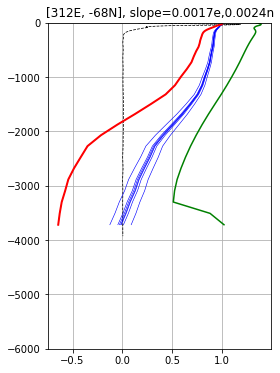

In [13]:
lati = 3
loni = 5
Ki = 0
mi = 1
f, ax = plt.subplots(1,1,figsize=(4,6))
ax.plot(20000*N2_in[:,lat_i[lati],lon_i[loni]],z_in,color='k',linewidth=0.75,linestyle='--')
for i in range(np.shape(modes_o)[3]):
    ax.plot(modes_o[lati,loni,Ki,i,:,mi],z_out,color='b',linewidth=0.6)
ax.plot(modes_o[lati,loni,Ki,np.int(fbmi[lati,loni]),:,mi],z_out,color='r',linewidth=2)
if np.nanmean(data.EOFu[:,lat_i[lati],lon_i[loni]][0:5] < 0):
    ax.plot(7.5*-1*data.EOFu[:,lat_i[lati],lon_i[loni]],-1*data.z,color='g')
else:
    ax.plot(7.5*1*data.EOFu[:,lat_i[lati],lon_i[loni]],-1*data.z,color='g')
ax.set_title('[' + str(lon_in[lon_i[loni]]) + 'E, ' + str(lat_in[lat_i[lati]]) + 'N], slope=' + \
             str(np.round(gamma_in[lat_i[lati], lon_i[loni]],4)) + 'e,' + str(np.round(alpha_in[lat_i[lati], lon_i[loni]],4)) + 'n')
ax.set_ylim([-6000,0])
ax.grid()

In [14]:
# for non-fb modes estimate decay rate 
mi = 1
decay = np.nan*np.ones((len(lat_i), len(lon_i)))
for i in tqdm(range(np.shape(modes_o)[0])):
    for j in range(np.shape(modes_o)[1]):
        if np.isnan(fbmi[i,j]):
            continue
        if fbmi[i,j] > 0:
            sbmi = np.concatenate((np.arange(0,np.int(fbmi[i,j])),np.arange(np.int(fbmi[i,j])+1,nazimuths)))
        else:
            sbmi = np.arange(np.int(fbmi[i,j])+1,nazimuths)
        mean_sbm = np.flip(np.nanmean(modes_o[i,j,0,sbmi,:,mi],axis=0))
        good = np.where(~np.isnan(mean_sbm))[0]
        decay[i,j] = np.nanmean(mean_sbm[good[-4:]])/np.nanmean(mean_sbm[0:4])

100%|██████████| 32/32 [00:00<00:00, 241.46it/s]


(-80.0, 80.0)

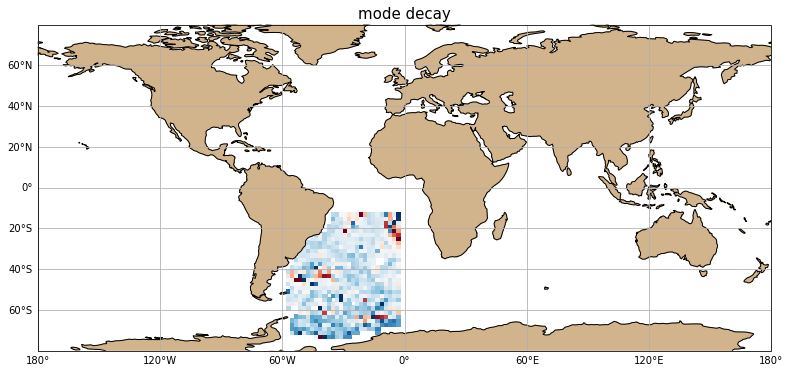

In [15]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lon_in[lon_i],lat_in[lat_i],decay,cmap=plt.get_cmap('RdBu'),vmin=-0.4,vmax=0.4)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('mode decay',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
ax.set_xlim([-180,180])
ax.set_ylim([-80,80])